## Reference

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://pytorch.org/vision/stable/transforms.html

## Libraries

In [43]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

from sklearn.metrics import classification_report, confusion_matrix

# Tracking progress
from tqdm import tqdm

# Set Seed
torch.manual_seed(2021)

plt.ion()   # interactive mode

## Load Data

In [36]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/ubuntu/data/2A_images_reorg2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
        
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print(dataset_sizes)
print(class_names)

{'train': 143778, 'val': 25486, 'test': 25658}
['Covid', 'Normal', 'Pneumonia']


## Sample Image

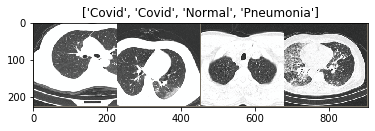

In [8]:
def imshow(inp, title=None):   
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model Function

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, train_='train'):    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'epoch':[],'train_loss':[],'train_acc':[],"val_loss":[],'val_acc':[]}

    for epoch in tqdm(range(num_epochs), position=0, leave=True):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        history['epoch'].append(epoch)

        # Each epoch has a training and validation phase
        for phase in [train_, 'val']:
            if phase == train_:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == train_:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # store statistics
            if phase == train_:
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Visual Model Predictions

In [10]:
def visualize_model(model, num_images=6, pred_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    eval_history = {'predict':[], 'actual':[]}

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            prob = nn.functional.softmax(outputs, dim=1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if images_so_far <= num_images:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('(pred,actual): ({0},{1},{2})'.\
                                 format(class_names[preds[j]], 
                                        class_names[labels[j]],
                                        round(prob[j][preds[j]].item(),3)))
                    imshow(inputs.cpu().data[j])

                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                
                elif images_so_far < pred_images:
                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                    
                elif images_so_far == pred_images:
                    model.train(mode=was_training)
                    return eval_history
        model.train(mode=was_training)

## Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [21]:
# Load pretratined model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Reset final fully connected layer
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Model to GPU
model_ft = model_ft.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
#models.resnet18(pretrained=True)

## Train 

The full trainset is used below.  Train model - 3hrs

In [27]:
model_ft_full, history_full = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15, train_='train')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/14
----------
train Loss: 0.2425 Acc: 0.9190


  7%|▋         | 1/15 [11:23<2:39:25, 683.26s/it]

val Loss: 0.0735 Acc: 0.9761

Epoch 1/14
----------
train Loss: 0.1134 Acc: 0.9602


 13%|█▎        | 2/15 [22:49<2:28:12, 684.05s/it]

val Loss: 0.0506 Acc: 0.9829

Epoch 2/14
----------
train Loss: 0.0865 Acc: 0.9690


 20%|██        | 3/15 [34:17<2:17:04, 685.37s/it]

val Loss: 0.0663 Acc: 0.9779

Epoch 3/14
----------
train Loss: 0.0734 Acc: 0.9742


 27%|██▋       | 4/15 [45:43<2:05:41, 685.62s/it]

val Loss: 0.0413 Acc: 0.9849

Epoch 4/14
----------
train Loss: 0.0641 Acc: 0.9776


 33%|███▎      | 5/15 [57:06<1:54:07, 684.77s/it]

val Loss: 0.0707 Acc: 0.9742

Epoch 5/14
----------
train Loss: 0.0581 Acc: 0.9791


 40%|████      | 6/15 [1:08:34<1:42:51, 685.73s/it]

val Loss: 0.0721 Acc: 0.9754

Epoch 6/14
----------
train Loss: 0.0537 Acc: 0.9811


 47%|████▋     | 7/15 [1:20:00<1:31:26, 685.78s/it]

val Loss: 0.0352 Acc: 0.9878

Epoch 7/14
----------
train Loss: 0.0352 Acc: 0.9877


 53%|█████▎    | 8/15 [1:31:24<1:19:55, 685.13s/it]

val Loss: 0.0359 Acc: 0.9866

Epoch 8/14
----------
train Loss: 0.0324 Acc: 0.9886


 60%|██████    | 9/15 [1:42:52<1:08:37, 686.22s/it]

val Loss: 0.0284 Acc: 0.9912

Epoch 9/14
----------
train Loss: 0.0294 Acc: 0.9895


 67%|██████▋   | 10/15 [1:54:17<57:09, 685.88s/it] 

val Loss: 0.0283 Acc: 0.9914

Epoch 10/14
----------
train Loss: 0.0293 Acc: 0.9898


 73%|███████▎  | 11/15 [2:05:44<45:44, 686.24s/it]

val Loss: 0.0329 Acc: 0.9879

Epoch 11/14
----------
train Loss: 0.0295 Acc: 0.9898


 80%|████████  | 12/15 [2:17:07<34:15, 685.20s/it]

val Loss: 0.0374 Acc: 0.9865

Epoch 12/14
----------
train Loss: 0.0280 Acc: 0.9905


 87%|████████▋ | 13/15 [2:28:31<22:49, 684.83s/it]

val Loss: 0.0487 Acc: 0.9838

Epoch 13/14
----------
train Loss: 0.0272 Acc: 0.9906


 93%|█████████▎| 14/15 [2:39:57<11:24, 685.00s/it]

val Loss: 0.0364 Acc: 0.9869

Epoch 14/14
----------
train Loss: 0.0265 Acc: 0.9909


100%|██████████| 15/15 [2:51:22<00:00, 685.48s/it]

val Loss: 0.0413 Acc: 0.9860

Training complete in 171m 22s
Best val Acc: 0.991407


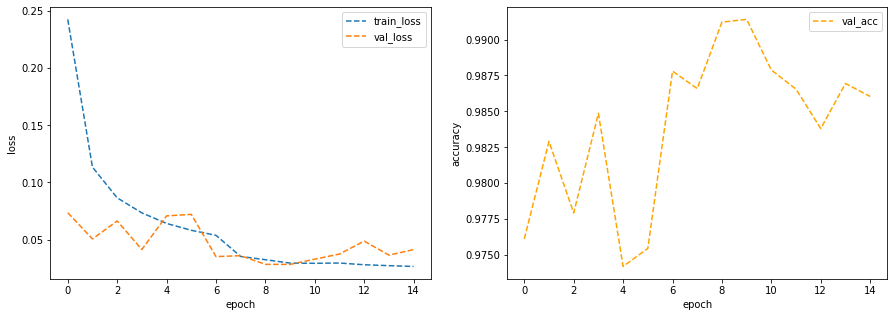

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

#  Loss
ax[0].plot(history_full['epoch'], history_full['train_loss'], 
           label='train_loss', linestyle='--')
ax[0].plot(history_full['epoch'], history_full['val_loss'], 
           label='val_loss', linestyle='--')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

# Accuracy
ax[1].plot(history_full['epoch'], history_full['val_acc'], 
           label='val_acc', linestyle='--', color='orange')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

Evaluate model

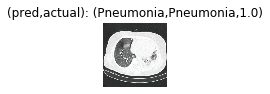

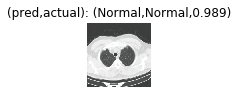

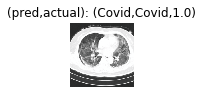

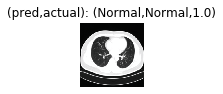

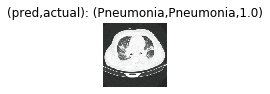

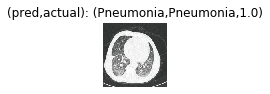

In [37]:
eval_history_full = visualize_model(model_ft_full, num_images=6, pred_images=dataset_sizes['test'])

In [38]:
print(classification_report(eval_history_full['actual'], eval_history_full['predict'], digits=3))

              precision    recall  f1-score   support

       Covid      0.970     0.996     0.983      6018
      Normal      0.997     0.989     0.993     12244
   Pneumonia      0.999     0.991     0.995      7395

    accuracy                          0.991     25657
   macro avg      0.989     0.992     0.990     25657
weighted avg      0.991     0.991     0.991     25657



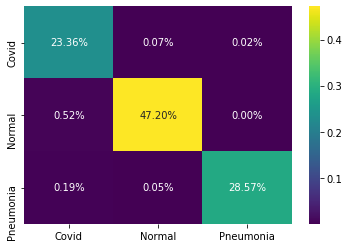

In [56]:
cf_matrix = confusion_matrix(eval_history_full['actual'], eval_history_full['predict'])

categories = ['Covid', 'Normal', 'Pneumonia']
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', xticklabels=categories, yticklabels=categories, cmap='viridis')

Export Model and History

In [58]:
# model
torch.save(model_ft_full.state_dict(), '/home/ubuntu/ResNet18_weights_full_reorg2')

In [ ]:
# train and test history


## Test for NX

In [24]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import PIL
import time

In [2]:
# Path of pre-trained model
PATH = '/home/ubuntu/w251_transfer_learning_weights'

In [116]:
# to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pretratined model into resnet18
model_tl = models.resnet18(pretrained=True)
num_ftrs = model_tl.fc.in_features

# Load pretrained weights into FC layer
model_tl.fc = nn.Linear(num_ftrs, 3)
model_tl.load_state_dict(torch.load(PATH))

# Push model to GPU
model_tl = model_tl.to(device)

In [121]:
def prediction(model, image):
    
    # Index for classes
    class_names = ['Covid', 'Normal', 'Pneumonia']
    
    # Put model to evaluation mode
    model.eval()  

    # Transform image for the model
    data_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    inputs = data_transform(image) 
    
    # Make 4D for Resnet: (batch, channel, width, height)
    inputs = inputs.cuda().float().unsqueeze(0)   
    
    # Prediction with model - outputs class and probability
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        prob = nn.functional.softmax(outputs, dim=1)
        
        print(class_names[preds[0]], ': %0.3f' %prob[0][preds[0]].item())

In [125]:
image = os.listdir('/home/ubuntu/data/2A_images_reorg/test/Pneumonia')[300]
image_path = '/home/ubuntu/data/2A_images_reorg/test/Pneumonia/' + image

# Read in image using CV2 and convert to PIL for transformations
img = cv2.imread(image_path)
img = PIL.Image.fromarray(img).convert('RGB')

In [126]:
prediction(model_tl, img)

Pneumonia : 1.000
